# Interactive AMR Testing Notebook

**Purpose:** Manual exploration and debugging of the DRL-AMR environment.

This notebook provides an interactive widget interface to:
- Select individual mesh elements
- Apply refinement/coarsening actions manually
- Observe reward calculations and solution changes
- Advance the physical simulation timestep-by-step

**Usage:**
1. Run all cells
2. Use the Element slider to select an element
3. Choose an action (Refine/No Change/Coarsen)
4. Click "Apply Action" to execute and see results

**Note:** This is a debugging/exploration tool, not part of the production workflow.

In [1]:
"""
Cell 1: Imports and Configuration
Sets up the environment, imports required modules, and configures matplotlib for SVG output.
"""
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import display as ipython_display

# Configure matplotlib for SVG output
matplotlib.rcParams['savefig.format'] = 'svg'
matplotlib.rcParams['svg.fonttype'] = 'none'  # Keep fonts as text (not paths)
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.transparent'] = False

# Add project root to path for imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

# Project imports
# from numerical.solvers.dg_wave_solver_mixed_clean import DGWaveSolverMixed
from numerical.solvers.dg_advection_solver import DGAdvectionSolver
# from numerical.environments.dg_amr_env_mixed import DGAMREnv, RewardCalculator
from numerical.environments.dg_amr_env import DGAMREnv, RewardCalculator

# Action name mapping for display
ACTION_NAMES = {-1: "Coarsen", 0: "No Change", 1: "Refine"}

In [2]:


class InteractiveAMRTester:
    """Interactive widget-based environment for testing AMR actions manually.
    
    Provides a Jupyter notebook interface to:
    - Select mesh elements and apply refinement/coarsening actions
    - Visualize mesh state, solution, and reward components
    - Track action history and resource usage
    - Advance physical simulation timesteps
    
    Args:
        nop: Polynomial order for DG basis. Defaults to 4.
        initial_elements: Initial element boundary coordinates.
        max_level: Maximum refinement level. Defaults to 4.
        element_budget: Maximum allowed elements. Defaults to 25.
        gamma_c: Reward scaling factor for resource penalty. Defaults to 25.0.
        machine_eps: Small constant for numerical stability. Defaults to 1e-16.
        initial_refinement_level: Starting refinement level. Defaults to 1.
        accuracy_scaling: Scaling factor for accuracy term. Defaults to 1.0.
        icase: Test case for exact solution. Defaults to 1.
    
    Example:
        >>> tester = InteractiveAMRTester(nop=4, element_budget=25, icase=1)
        >>> tester.show_tester()
    """
    
    def __init__(self, 
                 nop=4, 
                 initial_elements=np.array([-1, -0.5, 0, 0.5, 1]), 
                 max_level=4,
                 element_budget=25,
                 gamma_c=25.0,
                 machine_eps=1e-16,
                 initial_refinement_level=1,
                 accuracy_scaling=1.0,
                 icase=1):
        """Initialize the interactive tester with solver and environment."""
        # Store parameters
        self.nop = nop
        self.initial_elements = initial_elements
        self.max_level = max_level
        self.element_budget = element_budget
        self.gamma_c = gamma_c
        self.machine_eps = machine_eps
        self.accuracy_scaling = accuracy_scaling
        self.icase = icase
        
        # Create solver and environment
        self.create_environment(initial_refinement_level)
        
        # Initialize action/state history tracking
        self.action_history = []
        self.reward_history = []
        self.element_history = []
        self.delta_u_history = []
        self.resource_history = []
        
        # Setup reward calculator for inspection
        self.reward_calc = RewardCalculator(gamma_c=gamma_c)
        self.reward_calc.machine_eps = machine_eps

        # Auto-save SVG flag (disabled by default to avoid saving on every action)
        self.auto_save_svg = False

        # Create console output widget for displaying action results
        self.output_area = widgets.Output(
            layout={
                'border': '1px solid #ccc',
                'padding': '10px',
                'height': '300px',
                'overflow_y': 'auto',
                'font-family': 'monospace',
                'background-color': '#f9f9f9',
                'margin-top': '20px'
            }
        )
        
        # Create interactive control widgets
        self.setup_widgets()
        
        # Initialize console with message
        with self.output_area:
            print("=== AMR Testing Console Output ===")
            print(f"Initial state: {len(self.env.solver.active)}/{self.element_budget} elements")
            print("Use the controls to select elements and apply actions.\n")

    def console_print(self, *args, **kwargs):
        """Print to the notebook output widget instead of standard console."""
        with self.output_area:
            print(*args, **kwargs)

        
    def save_current_plot_svg(self, filename=None):
            """Save the current figure as SVG.
            
            Args:
                filename: Output filename. If None, generates timestamped name.
                
            Returns:
                Filename if saved successfully, None otherwise.
            """
            import time
            
            if filename is None:
                filename = f'amr_plot_{int(time.time())}.svg'
            
            if hasattr(self, 'current_fig') and self.current_fig is not None:
                self.current_fig.savefig(filename, format='svg', bbox_inches='tight')
                self.console_print(f"Saved as {filename}")
                return filename
            else:
                self.console_print("No current figure available to save")
                return None


    def debug_data_structures(self):
        """Print debug information about solver data structures (debug utility)."""
        self.console_print("\nDebugging Data Structures:")
        
        self.console_print(f"xelem: shape={np.shape(self.env.solver.xelem)}")
        self.console_print(f"xelem first few elements: {self.env.solver.xelem[:5]}")
        
        self.console_print(f"active elements: count={len(self.env.solver.active)}")
        self.console_print(f"active first few elements: {self.env.solver.active[:5]}")
        
        self.console_print(f"label_mat: shape={np.shape(self.env.solver.label_mat)}")
        if len(self.env.solver.active) > 0:
            first_elem = self.env.solver.active[0]
            self.console_print(f"label_mat for first element: {self.env.solver.label_mat[first_elem-1]}")
        
        self.console_print(f"info_mat: shape={np.shape(self.env.solver.info_mat)}")
        if len(self.env.solver.active) > 0:
            first_elem = self.env.solver.active[0]
            self.console_print(f"info_mat for first element: {self.env.solver.info_mat[first_elem-1]}")

    def create_environment(self, initial_refinement_level):
        """Create the solver and environment objects.
        
        Args:
            initial_refinement_level: Initial uniform refinement level for mesh.
        """
        # Create DG solversolver
        self.solver = DGAdvectionSolver(
            nop=self.nop,
            xelem=self.initial_elements,
            max_elements=self.element_budget * 2,
            max_level=self.max_level,
            courant_max=0.1,
            # icase=1,
            icase = self.icase,
            verbose=True,
            balance=False  # Disable balance for simplicity
        )
        
        # Create RL environment wrapping the solver
        self.env = DGAMREnv(
            solver=self.solver,
            element_budget=self.element_budget,
            gamma_c=self.gamma_c,
            max_episode_steps=100,
            verbose=True,
            rl_iterations_per_timestep=100,
            max_rl_iterations=5,
            debug_training_cycle=True  # Enable detailed debugging
        )
        
        # Reset environment with specified refinement level
        self.obs, self.info = self.env.reset(options={
            'refinement_mode': 'fixed',
            'refinement_level': initial_refinement_level
        })
        
        # Store initial state
        self.previous_solution = self.env.solver.q.copy()
        self.previous_resource = len(self.env.solver.active) / self.element_budget
        self.selected_element = None
        self.selected_action = None
            
        
    def setup_widgets(self):
        """Create the interactive control widgets for the notebook interface."""
        
        # --- Element and Action Selection ---
        self.element_slider = widgets.IntSlider(
            min=1,
            max=len(self.env.solver.active),
            step=1,
            description='Element:',
            continuous_update=False
        )
        
        self.action_radio = widgets.RadioButtons(
            options=[('Coarsen', 0), ('No Change', 1), ('Refine', 2)],
            description='Action:',
            disabled=False
        )
        
        # --- Action Buttons ---
        self.apply_button = widgets.Button(
            description='Apply Action',
            button_style='success',
            tooltip='Apply the selected action to the selected element'
        )
        self.apply_button.on_click(self.on_apply_action)
        
        self.reset_button = widgets.Button(
            description='Reset Environment',
            button_style='warning',
            tooltip='Reset the environment to initial state'
        )
        self.reset_button.on_click(self.on_reset)
        
        self.timestep_button = widgets.Button(
            description='Take Timestep',
            button_style='primary',
            tooltip='Advance the physical simulation one timestep'
        )
        self.timestep_button.on_click(self.on_take_timestep)
        
        self.save_button = widgets.Button(
            description='Save SVG',
            button_style='',
            tooltip='Save current plot as SVG file'
        )
        self.save_button.on_click(lambda b: self.save_current_plot_svg())
        
        # --- Environment Settings ---
        self.budget_slider = widgets.IntSlider(
            min=5, max=50, step=5,
            value=self.element_budget,
            description='Budget:',
            continuous_update=False
        )
        
        self.gamma_slider = widgets.FloatSlider(
            min=1.0, max=100.0, step=1.0,
            value=self.gamma_c,
            description='Gamma_c:',
            continuous_update=False
        )
        
        self.epsilon_slider = widgets.FloatLogSlider(
            base=10,
            min=-16, max=-4, step=1,  # 10^-16 to 10^-4
            value=self.machine_eps,
            description='Machine ε:',
            continuous_update=False
        )
        
        self.scaling_slider = widgets.FloatSlider(
            min=0.01, max=2.0, step=0.01,
            value=self.accuracy_scaling,
            description='Acc. Scale:',
            continuous_update=False
        )
        
        self.settings_button = widgets.Button(
            description='Apply Settings',
            button_style='info',
            tooltip='Apply new environment settings (resets environment)'
        )
        self.settings_button.on_click(self.on_apply_settings)
        
        # --- Auto-save SVG Checkbox ---
        self.auto_save_checkbox = widgets.Checkbox(
            value=self.auto_save_svg,
            description='Auto-save SVG',
            tooltip='Automatically save SVG after each action'
        )
        self.auto_save_checkbox.observe(self.on_auto_save_changed, names='value')
        
        # --- Layout Arrangement ---
        self.element_action_box = widgets.VBox([
            self.element_slider,
            self.action_radio,
            self.apply_button
        ])
        
        self.settings_box = widgets.VBox([
            self.budget_slider,
            self.gamma_slider,
            self.epsilon_slider,
            self.scaling_slider,
            self.settings_button
        ])
        
        self.control_box = widgets.HBox([
            self.element_action_box,
            widgets.VBox([self.reset_button, self.timestep_button, self.save_button, self.auto_save_checkbox]),
            self.settings_box
        ])

    def on_auto_save_changed(self, change):
        """Callback when auto-save checkbox is toggled."""
        self.auto_save_svg = change['new']
        self.console_print(f"Auto-save SVG: {'enabled' if self.auto_save_svg else 'disabled'}")
        

    def on_apply_action(self, b):
        """Callback for when the apply action button is clicked"""
        self.selected_element = self.element_slider.value
        self.selected_action = self.action_radio.value
        
        # Get pre-action state
        pre_elements = len(self.env.solver.active)
        pre_resource = pre_elements / self.element_budget
        
        # Convert element index to active element ID
        if self.selected_element <= len(self.env.solver.active):
            element_id = self.env.solver.active[self.selected_element - 1]
        else:
            print(f"Error: Selected element {self.selected_element} out of range")
            return
        
        # Get the mapped action (-1, 0, 1)
        mapped_action = self.env.action_mapping[self.selected_action]
        
        # Store the previous solution and coordinates for visualization
        self.previous_solution = self.env.solver.q.copy()
        self.previous_coord = self.env.solver.coord.copy()
        self.previous_resources = pre_resource
        
    
        # Display action information using console_print
        self.console_print(f"\nApplying {ACTION_NAMES[mapped_action]} to element {self.selected_element} (ID: {element_id})")
        # print(f"\nApplying {ACTION_NAMES[mapped_action]} to element {self.selected_element} (ID: {element_id})")
        
        # Save current element index
        original_element_index = self.env.current_element_index
        
        # Set environment's current element index to our selected element
        self.env.current_element_index = self.selected_element - 1
        
        # Apply the action using the standard step method
        obs, reward, terminated, truncated, info = self.env.step(self.selected_action)
        
        # Restore original element index
        self.env.current_element_index = original_element_index
        
        # Get post-action state
        post_elements = len(self.env.solver.active)
        post_resource = post_elements / self.element_budget
        delta_elements = post_elements - pre_elements
        
        # Calculate change in solution
        if 'delta_u' in info:
            delta_u = info['delta_u']
        else:
            delta_u = 0.0
        
        # Calculate barrier function values (B(p) = √p/(1-p))
        def calculate_barrier(p):
            if p >= 1.0:
                return float('inf')  
            elif p <= 0.0:
                return 0.0
            else:
                return np.sqrt(p) / (1 - p)
                
        old_barrier = calculate_barrier(pre_resource)
        new_barrier = calculate_barrier(post_resource)
        barrier_delta = new_barrier - old_barrier
        
        # Update histories - STORE BOTH ELEMENT INDEX AND ID
        self.action_history.append({
            'action': ACTION_NAMES[mapped_action], 
            'element': self.selected_element,
            'element_id': element_id  # Store the actual element ID
        })
        
        # Rest of the method remains the same...
        self.reward_history.append({
            'total': reward, 
            'accuracy': info.get('accuracy_term', 0.0), 
            'penalty': info.get('resource_penalty', 0.0)
        })
        
        self.resource_history.append({
            'pre': pre_resource,
            'post': post_resource,
            'delta': post_resource - pre_resource,
            'old_barrier': old_barrier,
            'new_barrier': new_barrier,
            'barrier_delta': barrier_delta
        })
        
        self.element_history.append({
            'pre': pre_elements,
            'post': post_elements,
            'delta': delta_elements
        })
        
        self.delta_u_history.append(delta_u)
        
        # Print detailed results
        # Print detailed results using console_print
        self.console_print(f"Action result:")
        self.console_print(f"  Reward: {reward:.4f}")
        self.console_print(f"  Δu (solution change): {delta_u:.6e}")
        self.console_print(f"  Elements: {pre_elements} → {post_elements} (Δ{delta_elements:+d})")
        self.console_print(f"  Resource usage: {pre_resource*100:.1f}% → {post_resource*100:.1f}%")
        self.console_print(f"  Barrier function: {old_barrier:.4f} → {new_barrier:.4f} (Δ{barrier_delta:+.4f})")

        # print(f"Action result:")
        # print(f"  Reward: {reward:.4f}")
        # print(f"  Δu (solution change): {delta_u:.6e}")
        # print(f"  Elements: {pre_elements} → {post_elements} (Δ{delta_elements:+d})")
        # print(f"  Resource usage: {pre_resource*100:.1f}% → {post_resource*100:.1f}%")
        # print(f"  Barrier function: {old_barrier:.4f} → {new_barrier:.4f} (Δ{barrier_delta:+.4f})")
        
        # Update visualization
        self.render()

        current_element_count = len(self.env.solver.active)
        self.element_slider.max = current_element_count
        
        # If selected element is out of range, reset to center
        if self.selected_element > current_element_count:
            self.element_slider.value = current_element_count // 2
        
        # Update the slider's description to show the new range
        self.element_slider.description = f'Element (1-{current_element_count}):'
        
        # If max refinement level reached, notify user
        element_level = info.get('element_level', -1)
        if mapped_action == 1 and element_level == self.env.solver.max_level:
            self.console_print(f"Note: Element {element_id} already at maximum refinement level ({self.env.solver.max_level})")
            print(f"Note: Element {element_id} already at maximum refinement level ({self.env.solver.max_level})")
        elif mapped_action == -1 and element_level == 0:
            self.console_print(f"Note: Element {element_id} already at base level (0)")
            print(f"Note: Element {element_id} already at base level (0)")    
   

    
    
    def on_reset(self, b):
        """Reset the environment"""
        initial_refinement = int(np.log2(len(self.env.solver.active) / (len(self.initial_elements) - 1)))
        initial_refinement = max(1, min(initial_refinement, self.max_level))
        
        self.console_print(f"Resetting environment with refinement level {initial_refinement}...")
        self.obs, self.info = self.env.reset(options={
            'refinement_mode': 'fixed',
            'refinement_level': initial_refinement
        })
        
        # Reset history
        self.action_history = []
        self.reward_history = []
        self.element_history = []
        self.delta_u_history = []
        self.resource_history = []
        
        # Store initial state
        self.previous_solution = self.env.solver.q.copy()
        self.previous_coord = self.env.solver.coord.copy()
        self.previous_resource = len(self.env.solver.active) / self.element_budget
        self.selected_element = None
        self.selected_action = None
        
        # Update slider max value
        self.element_slider.max = len(self.env.solver.active)
        self.element_slider.value = 1
        
        # Render the reset state
        self.render()
        self.console_print("Environment reset complete.")   
    

    def on_apply_settings(self, b):
        """Apply new environment settings"""
        # Extract settings from widgets
        new_budget = self.budget_slider.value
        new_gamma = self.gamma_slider.value
        new_epsilon = self.epsilon_slider.value
        new_scaling = self.scaling_slider.value
        
        self.console_print(f"Applying new settings: Budget={new_budget}, Gamma={new_gamma}, Epsilon={new_epsilon:.1e}, Scaling={new_scaling}")
        
        # Store current values
        self.element_budget = new_budget
        self.gamma_c = new_gamma
        self.machine_eps = new_epsilon
        self.accuracy_scaling = new_scaling
        
        # Create new environment with these settings
        # Get current refinement level
        current_active = len(self.env.solver.active)
        current_refinement = int(np.log2(current_active / (len(self.initial_elements) - 1)))
        current_refinement = max(1, min(current_refinement, self.max_level))
        
        # Recreate environment with new settings
        self.create_environment(current_refinement)
        
        # Update reward calculator
        self.reward_calc = RewardCalculator(gamma_c=new_gamma)
        self.reward_calc.machine_eps = new_epsilon
        
        # Reset history since this is essentially a new environment
        self.action_history = []
        self.reward_history = []
        self.element_history = []
        self.delta_u_history = []
        self.resource_history = []
        
        # Update slider max value
        self.element_slider.max = len(self.env.solver.active)
        self.element_slider.value = 1
        
        # Render with new settings
        self.render()
        self.console_print("New settings applied successfully.")
        
    def on_take_timestep(self, b):
        """Advance the physical simulation by one timestep using the environment's mechanism"""
        self.console_print("\nAdvancing physical simulation by one timestep...")
        
        # Store pre-timestep solution and state
        pre_solution = self.env.solver.q.copy()
        pre_coord = self.env.solver.coord.copy()
        pre_elements = len(self.env.solver.active)
        pre_resource = pre_elements / self.element_budget
        pre_time = self.env.solver.time
        
        # Set the RL iteration counter to trigger a timestep on the next step
        original_iteration = self.env.current_rl_iteration
        self.env.current_rl_iteration = self.env.rl_iterations_per_timestep - 1
        
        # Take a "no change" action on the first element to trigger the timestep logic
        original_element_index = self.env.current_element_index
        self.env.current_element_index = 0  # Use the first element
        obs, reward, terminated, truncated, info = self.env.step(1)  # 1 = No Change action
        
        # Restore original element index
        self.env.current_element_index = original_element_index
        
        # Calculate solution change
        post_solution = self.env.solver.q.copy()
        solution_change = np.linalg.norm(post_solution - pre_solution)
        post_time = self.env.solver.time
        
        # Store previous solution for visualization
        self.previous_solution = pre_solution
        self.previous_coord = pre_coord
        
        # Update state tracking
        self.action_history.append({
            'element': None,
            'element_id': None,
            'action': "Timestep"
        })
        
        self.reward_history.append({
            'total': None,
            'accuracy': None,
            'penalty': None
        })
        
        self.element_history.append({
            'pre': pre_elements,
            'post': len(self.env.solver.active),
            'delta': len(self.env.solver.active) - pre_elements
        })
        
        self.delta_u_history.append(solution_change)
        self.resource_history.append({
            'pre': pre_resource,
            'post': len(self.env.solver.active) / self.element_budget,
            'old_barrier': None,
            'new_barrier': None
        })
        
        # Render updated state
        self.render()
        
        # Report more detailed information about the timestep
        time_delta = post_time - pre_time
        self.console_print(f"Timestep complete.")
        self.console_print(f"  Time: {pre_time:.4f} → {post_time:.4f} (Δt = {time_delta:.4e})")
        self.console_print(f"  Solution change: {solution_change:.6e}")
        self.console_print(f"  Elements: {pre_elements} → {len(self.env.solver.active)}")
        
        # Update slider max value if number of elements changed during timestep
        if pre_elements != len(self.env.solver.active):
            self.element_slider.max = len(self.env.solver.active)
            self.element_slider.description = f'Element (1-{len(self.env.solver.active)}):'

    def print_action_results(self, action, actual_action, delta_u, accuracy_term,
                                expected_accuracy, pre_resource, post_resource,
                                old_barrier, new_barrier, resource_penalty,
                                expected_reward, actual_reward, pre_elements, post_elements):
            """Print detailed results of the action"""
            self.console_print("\n=== Action Results ===")
            self.console_print(f"Action: {action} (Actual: {actual_action})")
            self.console_print(f"Elements: {pre_elements} -> {post_elements} (Δ{post_elements-pre_elements})")
            self.console_print(f"Resource: {pre_resource:.4f} -> {post_resource:.4f}")
            self.console_print("\n--- Solution Impact ---")
            self.console_print(f"Delta_u: {delta_u:.6e}")
            self.console_print(f"log(Delta_u): {np.log(abs(delta_u) + self.machine_eps):.4f}")
            self.console_print(f"Accuracy term (unscaled): {accuracy_term/self.accuracy_scaling:.4f}")
            self.console_print(f"Accuracy term (scaled): {accuracy_term:.4f}")
            self.console_print(f"Expected accuracy contribution: {expected_accuracy:.4f}")
            self.console_print("\n--- Resource Impact ---")
            self.console_print(f"Old barrier: {old_barrier:.4f}")
            self.console_print(f"New barrier: {new_barrier:.4f}")
            self.console_print(f"Resource penalty: {resource_penalty:.4f}")
            self.console_print(f"Scaled penalty (gamma_c={self.gamma_c}): {self.gamma_c * resource_penalty:.4f}")
            self.console_print("\n--- Final Reward ---")
            self.console_print(f"Expected reward: {expected_reward:.4f}")
            self.console_print(f"Actual reward: {actual_reward:.4f}")
            self.console_print("=====================\n")

    def render(self):
            """Render the current state with visualizations"""
            clear_output(wait=True)
            
            # Create figure with subplots
            fig = plt.figure(figsize=(18, 12))
            gs = gridspec.GridSpec(3, 3, figure=fig)
            
            # Subplot 1: Current mesh visualization
            ax1 = fig.add_subplot(gs[0, :])
            self.plot_mesh_state(ax1)
            
            # Subplot 2: Solution visualization
            ax2 = fig.add_subplot(gs[1, :])
            self.plot_solution(ax2)
            
            # Subplot 3: Action history
            ax3 = fig.add_subplot(gs[2, 0])
            self.plot_action_history(ax3)
            
            # Subplot 4: Reward history
            ax4 = fig.add_subplot(gs[2, 1])
            self.plot_reward_history(ax4)
            
            # Subplot 5: Resource usage
            ax5 = fig.add_subplot(gs[2, 2])
            self.plot_resource_history(ax5)
            
            plt.tight_layout()
            plt.show()

            self.current_fig = fig

            self.save_current_plot_svg()

            # Create layout with controls and console output
            main_layout = widgets.VBox([
                self.control_box,
                widgets.HTML("<h3>Console Output:</h3>"),
                self.output_area
            ])
            
            
            # Display the main layout
            ipython_display(main_layout)
            # display(self.control_box)
    
    def plot_mesh_state(self, ax):
        """Plot the current mesh state with element levels and correct element IDs"""
        # Get element boundaries and levels
        active_elements = self.env.solver.active
        xelem = self.env.solver.xelem  # Keep this for domain boundaries
        
        levels = []
        element_centers = []
        element_widths = []
        element_ids = []  # Store actual element IDs
        
        for i, elem_id in enumerate(active_elements):
            # Element levels (assuming 1-indexed elements)
            level = self.env.solver.label_mat[elem_id-1][4]
            levels.append(level)
            
            # Get left and right coordinates from info_mat (last two columns)
            x_left = self.env.solver.info_mat[elem_id-1][-2]
            x_right = self.env.solver.info_mat[elem_id-1][-1]
            
            width = x_right - x_left
            center = (x_left + x_right) / 2
            
            element_centers.append(center)
            element_widths.append(width)
            element_ids.append(elem_id)  # Store actual element ID
        
        # Find elements to highlight based on the last action
        highlight_elements = set()
        
        # If element is selected, highlight it
        if self.selected_element is not None and self.selected_element <= len(active_elements):
            highlight_elements.add(self.selected_element - 1)
        
        # Track refined/coarsened elements
        if self.action_history:
            last_action = self.action_history[-1]
            action_type = last_action.get('action')
            
            if action_type == "Refine" and 'element_id' in last_action:
                # This was the parent element that was refined
                parent_id = last_action.get('element_id')
                
                # Find its children in label_mat
                if parent_id <= len(self.env.solver.label_mat):
                    child1_id = self.env.solver.label_mat[parent_id-1][2]
                    child2_id = self.env.solver.label_mat[parent_id-1][3]
                    
                    # Find these children in the active list
                    for i, elem_id in enumerate(active_elements):
                        if elem_id == child1_id or elem_id == child2_id:
                            highlight_elements.add(i)
                            
            elif action_type == "Coarsen" and 'element_id' in last_action:
                # Find parent element of the coarsened elements
                child_id = last_action.get('element_id')
                
                if child_id <= len(self.env.solver.label_mat):
                    parent_id = self.env.solver.label_mat[child_id-1][1]
                    
                    # Find parent in active list
                    for i, elem_id in enumerate(active_elements):
                        if elem_id == parent_id:
                            highlight_elements.add(i)
        
        # Plot the elements as boxes with levels as heights
        for i, (center, width, level, elem_id) in enumerate(zip(element_centers, element_widths, levels, element_ids)):
            # Determine if this element should be highlighted
            is_highlighted = (i in highlight_elements)
            
            rect = patches.Rectangle(
                (center - width/2, 0), 
                width, level,
                linewidth=2,
                edgecolor='blue',
                facecolor='orange' if is_highlighted else 'lightblue',
                alpha=0.7
            )
            ax.add_patch(rect)
            
            # Add element IDs (not indices) to each element
            ax.text(center, level + 0.1, str(elem_id), 
                    ha='center', va='bottom', fontsize=10,
                    color='darkred' if is_highlighted else 'black',
                    fontweight='bold' if is_highlighted else 'normal')
        
        # Plot domain boundaries
        ax.axvline(xelem[0], color='black', linestyle='-')
        ax.axvline(xelem[-1], color='black', linestyle='-')
        
        ax.set_xlim(xelem[0] - 0.1, xelem[-1] + 0.1)
        ax.set_ylim(0, self.max_level + 1)
        ax.set_ylabel('Refinement Level')
        ax.set_xlabel('x coordinate')
        ax.set_title(f'Current Mesh State - {len(active_elements)}/{self.element_budget} Elements')
        ax.grid(True)
    


    def plot_solution(self, ax):
        """Plot the current solution on the mesh with previous solution shown as dashed line"""
        # Extract solution data
        x = self.env.solver.coord
        q = self.env.solver.q
        
        # Plot the previous solution if available
        if hasattr(self, 'previous_solution') and hasattr(self, 'previous_coord'):
            if self.previous_solution is not None and self.previous_coord is not None:
                ax.plot(self.previous_coord, self.previous_solution, color = 'darkmagenta',ls ='--', 
                        linewidth=2.5, alpha=0.8, label='Previous Solution')
        
        # Plot the current solution
        ax.plot(x, q, 'b-', linewidth=2, label='Current Solution')
        
        # Highlight boundaries between elements
        active_elements = self.env.solver.active
        for elem_id in active_elements:
            # Get actual coordinates from info_mat
            x_left = self.env.solver.info_mat[elem_id-1][-2]
            x_right = self.env.solver.info_mat[elem_id-1][-1]
            
            ax.axvline(x_left, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x_right, color='gray', linestyle='--', alpha=0.5)
        
        # Find elements to highlight based on selection and last action
        highlight_regions = []
        
        # If an element is selected, highlight it
        if self.selected_element is not None and self.selected_element <= len(active_elements):
            elem_id = active_elements[self.selected_element-1]
            x_left = self.env.solver.info_mat[elem_id-1][-2]
            x_right = self.env.solver.info_mat[elem_id-1][-1]
            highlight_regions.append((x_left, x_right, '', 'orange'))
            # highlight_regions.append((x_left, x_right,  'orange'))
        
        # Highlight elements affected by the last action
        if self.action_history:
            last_action = self.action_history[-1]
            action_type = last_action.get('action')
            
            if action_type == "Refine" and 'element_id' in last_action:
                # Get the parent element ID that was refined
                parent_id = last_action.get('element_id')
                
                # Find its children in label_mat
                if parent_id <= len(self.env.solver.label_mat):
                    child1_id = self.env.solver.label_mat[parent_id-1][2]
                    child2_id = self.env.solver.label_mat[parent_id-1][3]
                    
                    # Get the bounds of these child elements
                    if child1_id > 0 and child1_id <= len(self.env.solver.info_mat):
                        x_left = self.env.solver.info_mat[child1_id-1][-2]
                        x_right = self.env.solver.info_mat[child1_id-1][-1]
                        # highlight_regions.append((x_left, x_right, f'C {child1_id}', 'lightgreen'))
                        highlight_regions.append((x_left, x_right, '', 'lightgreen'))
                    
                    if child2_id > 0 and child2_id <= len(self.env.solver.info_mat):
                        x_left = self.env.solver.info_mat[child2_id-1][-2]
                        x_right = self.env.solver.info_mat[child2_id-1][-1]
                        # highlight_regions.append((x_left, x_right, f'C {child2_id}', 'lightgreen'))
                        highlight_regions.append((x_left, x_right,'',  'lightgreen'))
                        
            elif action_type == "Coarsen" and 'element_id' in last_action:
                # Get the child element ID that was coarsened
                child_id = last_action.get('element_id')
                
                # Find its parent in label_mat
                if child_id <= len(self.env.solver.label_mat):
                    parent_id = self.env.solver.label_mat[child_id-1][1]
                    
                    # Get the bounds of the parent element
                    if parent_id > 0 and parent_id <= len(self.env.solver.info_mat):
                        x_left = self.env.solver.info_mat[parent_id-1][-2]
                        x_right = self.env.solver.info_mat[parent_id-1][-1]
                        highlight_regions.append((x_left, x_right, f'P {parent_id}', 'lightgreen'))
        
        # Add shaded regions for affected elements
        for x_left, x_right, label, color in highlight_regions:
            ax.axvspan(x_left, x_right, alpha=0.3, color=color)
            
            # Add label for region
            ax.text((x_left + x_right)/2, ax.get_ylim()[1]*0.9, 
                    label, 
                    ha='center', va='center', 
                    bbox=dict(facecolor='white', alpha=0.7))
        
        ax.set_xlim(self.env.solver.xelem[0], self.env.solver.xelem[-1])
        ax.set_xlabel('x coordinate')
        ax.set_ylabel('Solution (q)')
        ax.set_title('Current Solution')
        # ax.legend(loc='best')
        ax.legend(bbox_to_anchor=(0.72, 0.58), loc='upper left')
        ax.grid(True)
 
    
        
    def plot_action_history(self, ax):
        """Plot the history of actions taken"""
        if not self.action_history:
            ax.text(0.5, 0.5, "No actions yet", ha='center', va='center')
            ax.set_title('Action History')
            ax.set_xticks([])
            ax.set_yticks([])
            return
        
        # Prepare data
        step_nums = range(1, len(self.action_history) + 1)
        action_types = [h['action'] for h in self.action_history]
        
        # Create color map for actions
        action_colors = {
            'Refine': 'green',
            'Coarsen': 'red',
            'No Change': 'blue',
            'Timestep': 'purple'
        }
        
        colors = [action_colors.get(a, 'gray') for a in action_types]
        
        # Plot action history as bars
        bars = ax.bar(step_nums, [1] * len(step_nums), color=colors)
        
        # Add action labels
        for i, (s, a) in enumerate(zip(step_nums, action_types)):
            ax.text(s, 0.5, a, ha='center', va='center', 
                    rotation=90 if len(a) > 5 else 0,
                    fontsize=8, color='white', fontweight='bold')
            
            # Add element number if available
            if self.action_history[i]['element'] is not None:
                ax.text(s, 1.1, f"#{self.action_history[i]['element']}", 
                        ha='center', va='bottom', fontsize=8)
        
        ax.set_ylim(0, 1.5)
        ax.set_xlim(0.5, len(step_nums) + 0.5)
        ax.set_xticks(step_nums)
        ax.set_xlabel('Step')
        ax.set_title('Action History')
        ax.set_yticks([])

    def plot_reward_history(self, ax):
        """Plot the history of rewards"""
        if not self.reward_history:
            ax.text(0.5, 0.5, "No rewards yet", ha='center', va='center')
            ax.set_title('Reward History')
            ax.set_xticks([])
            ax.set_yticks([])
            return
        
        # Prepare data
        step_nums = range(1, len(self.reward_history) + 1)
        
        # Filter out None values (from timesteps)
        valid_indices = [i for i, r in enumerate(self.reward_history) if r['total'] is not None]
        valid_steps = [step_nums[i] for i in valid_indices]
        
        if not valid_indices:
            ax.text(0.5, 0.5, "No rewards to display", ha='center', va='center')
            ax.set_title('Reward History')
            ax.set_xticks(step_nums)
            ax.set_xlabel('Step')
            return
        
        total_rewards = [self.reward_history[i]['total'] for i in valid_indices]
        accuracy_terms = [self.reward_history[i]['accuracy'] for i in valid_indices]
        penalty_terms = [-self.reward_history[i]['penalty'] for i in valid_indices]
        
        # Plot stacked bars for reward components
        ax.bar(valid_steps, accuracy_terms, color='green', label='Accuracy')
        ax.bar(valid_steps, penalty_terms, bottom=accuracy_terms, color='red', label='Resource Penalty')
        
        # Plot total reward as a line
        ax.plot(valid_steps, total_rewards, 'ko-', label='Total Reward')
        
        # Add y=0 line
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        ax.set_xlabel('Step')
        ax.set_ylabel('Reward Value')
        ax.set_title('Reward Components')
        ax.legend(loc='upper left', fontsize='small')
        ax.set_xticks(step_nums)
        
        # Add delta_u values as text
        for i, step in enumerate(valid_steps):
            delta_u = self.delta_u_history[step-1]
            if delta_u > 0:
                ax.text(step, total_rewards[i], 
                        f"Δu={delta_u:.2e}", 
                        ha='center', va='bottom', fontsize=8)

    def plot_resource_history(self, ax):
        """Plot the history of resource usage"""
        if not self.resource_history:
            ax.text(0.5, 0.5, "No resource data yet", ha='center', va='center')
            ax.set_title('Resource Usage')
            ax.set_xticks([])
            ax.set_yticks([])
            return
        
        # Prepare data
        step_nums = range(1, len(self.resource_history) + 1)
        post_resources = [r['post'] for r in self.resource_history]
        
        # Plot resource usage
        ax.plot(step_nums, post_resources, 'bo-', label='Resource Usage')
        
        # Add budget line
        ax.axhline(y=1.0, color='red', linestyle='--', label='Budget Limit')
        
        # Add barrier function values if available
        valid_indices = [i for i, r in enumerate(self.resource_history) if r['new_barrier'] is not None]
        if valid_indices:
            valid_steps = [step_nums[i] for i in valid_indices]
            barrier_values = [self.resource_history[i]['new_barrier'] / 10 for i in valid_indices]  # Scale down for visibility
            
            ax.plot(valid_steps, barrier_values, 'g.-', label='Barrier/10')
        
        ax.set_xlabel('Step')
        ax.set_ylabel('Resource Usage (p)')
        ax.set_title('Resource Usage History')
        ax.legend(loc='upper left', fontsize='small')
        ax.set_xticks(step_nums)
        ax.set_ylim(0, max(1.1, max(post_resources) * 1.1))
        
        # Add element counts as text
        for i, step in enumerate(step_nums):
            elements = self.element_history[i]['post']
            ax.text(step, post_resources[i], 
                    f"{elements}", 
                    ha='center', va='bottom', fontsize=8)

    def show_tester(self):
        """Initialize and display the interactive tester"""
        self.render()
        with self.output_area:
            print("Interactive AMR Tester initialized.")
            print(f"Initial state: {len(self.env.solver.active)}/{self.element_budget} elements")
            print("Use the widgets below to select elements and apply actions.")

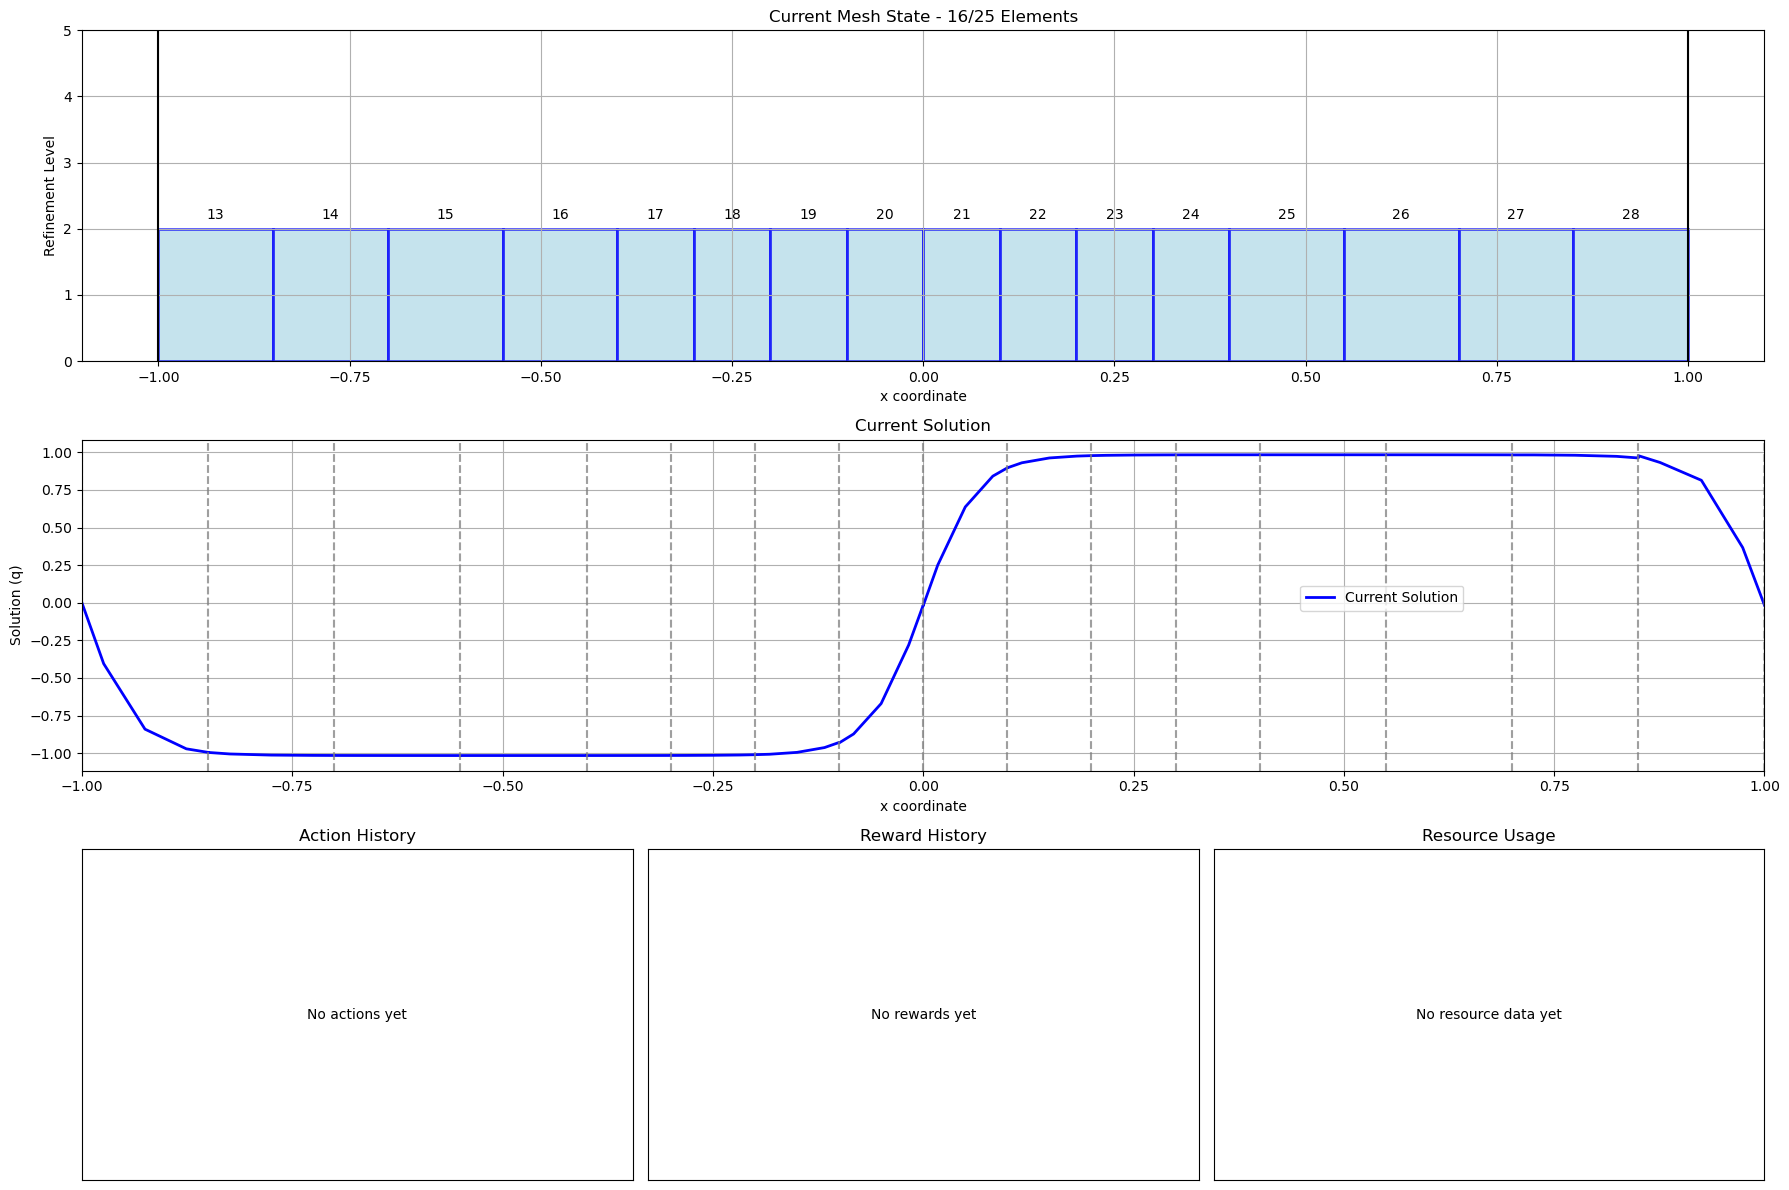

In [3]:
"""
Cell 3: Create and Launch Interactive Tester
Instantiate the tester with desired parameters and display the interface.
"""
tester = InteractiveAMRTester(
    nop=4,                                            # Polynomial order
    initial_elements=np.array([-1, -0.5, 0, 0.5, 1]), # Initial mesh boundaries
    max_level=4,                                      # Max refinement level
    element_budget=25,                                # Max allowed elements
    gamma_c=25.0,                                     # Resource penalty scaling
    machine_eps=1e-16,                                # Numerical stability constant
    initial_refinement_level=2,                       # Starting refinement
    accuracy_scaling=1.0,                             # Accuracy term scaling
    icase=10                                          # Test case (10 = tanh smooth square)
)
tester.show_tester()

In [ ]:
"""
Cell 4: Manual SVG Save (Optional)
Use this if the Save SVG button doesn't capture the plot correctly.
"""
# Save the current figure manually
if hasattr(tester, 'current_fig') and tester.current_fig is not None:
    tester.current_fig.savefig('amr_manual_save.svg', format='svg', bbox_inches='tight')
    print("Saved as amr_manual_save.svg")
else:
    print("No figure available. Run an action first.")

Saved current plot as SVG!


<Figure size 640x480 with 0 Axes>